In [1]:
from streamer import NIStreamer
import numpy as np
from utils import iplot

## Isolated card

### Simplest test

In [3]:
ni_streamer = NIStreamer()

In [4]:
ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot3',
    samp_rate=1e6
)

In [5]:
my_ao = ao_card.add_chan(chan_idx=0)

In [7]:
total_dur = 10.0
freq = 1e3
amp = 0.5

my_ao.sine(
    t=0,
    dur=total_dur,
    amp=amp, freq=freq
)

10.0

In [8]:
ni_streamer.compile()

10.0

In [11]:
iplot(
    chan_list=[my_ao],
    nsamps=1e6
)

In [18]:
ni_streamer.stream_exp()

Everything looks correct on the scope trace.

### Higher frequency sine (100 kHz)

In [2]:
ni_streamer = NIStreamer()

In [3]:
ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot3',
    samp_rate=1e6
)

In [4]:
my_ao = ao_card.add_chan(chan_idx=0)

In [5]:
total_dur = 10.0
freq = 100e3
amp = 0.5

my_ao.sine(
    t=0,
    dur=total_dur,
    amp=amp, freq=freq
)

10.0

In [10]:
ni_streamer.compile()

10.0

In [9]:
iplot(
    chan_list=[my_ao],
    nsamps=1e6,
    t_end=1.0,
    row_height=500
)

In [16]:
ni_streamer.stream_exp()

Scope traces:
- sine shape is very clear
- period is quite precisely 10 us
- amplitude is slightly reduced to about 410 mV
- initial transient from constant 0 to sine (starting from 0) is visible

### Complicated sequence, but still isolated AO card (no exporting)

In [2]:
ni_streamer = NIStreamer()

In [3]:
ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot3',
    samp_rate=1e6
)

In [4]:
my_ao = ao_card.add_chan(chan_idx=0)

In [5]:
ni_streamer.clear_edit_cache()

total_dur = 10.0
instr_dur = 10e-3
instr_num = int(total_dur // instr_dur)

# AO pulse settings
amp = 0.5
freq = 100e3
buf = 50e-6

t = 0
for idx in range(instr_num):
    
    my_ao.sine(
        t=t, dur=instr_dur - buf,
        amp=amp, freq=freq
    )
        
    t += instr_dur

In [9]:
ni_streamer.compile()

9.989949

In [8]:
iplot(
    chan_list=[my_ao],
    nsamps=1e6,
    t_end=1.0,
    row_height=500
)

In [18]:
ni_streamer.stream_exp()

Notes:

- Sine elements are correct (10 us period, just above 400 mV amplitude)
- block duration is accurately 10 ms, inter-block gap is precisely 50 us

The only noted deviation: after the whole sequnce, kept value is not 0 (close to -300mV; probably because compiler throws away the final instruction "constant(0)")

## Several cards

### Minimal waveform (a single sine). Try exporting start trig and ref clock (but not importing in on any other card yet)

In [1]:
ni_streamer = NIStreamer()

In [3]:
ao_card = ni_streamer.add_ao_card(
    max_name='PXI1Slot3',
    samp_rate=1e6
)

In [4]:
TRIG_LINE = 'PXI_Trig0'
REF_CLK_LINE = 'PXI_Trig7'

In [5]:
ao_card.cfg_start_trig(
    line=TRIG_LINE,
    export=True
)
ao_card.cfg_ref_clk(
    line=REF_CLK_LINE,
    export=True
)

In [4]:
ao_card

AO card PXI1Slot3
	Sample clock: Using 1,000,000.0 Hz onboard sample clock
	Start trigger: Not using external start trigger
	Reference clock: Not using external reference clock

In [5]:
my_ao = ao_card.add_chan(chan_idx=0)

In [6]:
total_dur = 10.0
freq = 100e3
amp = 0.5

my_ao.sine(
    t=0,
    dur=total_dur,
    amp=amp, freq=freq
)

10.0

In [7]:
ni_streamer.compile()

10.0

In [9]:
iplot(
    chan_list=[my_ao],
    nsamps=1e6,
    t_end=1.0,
    row_height=500
)

In [10]:
ni_streamer.stream_exp()

Not exported
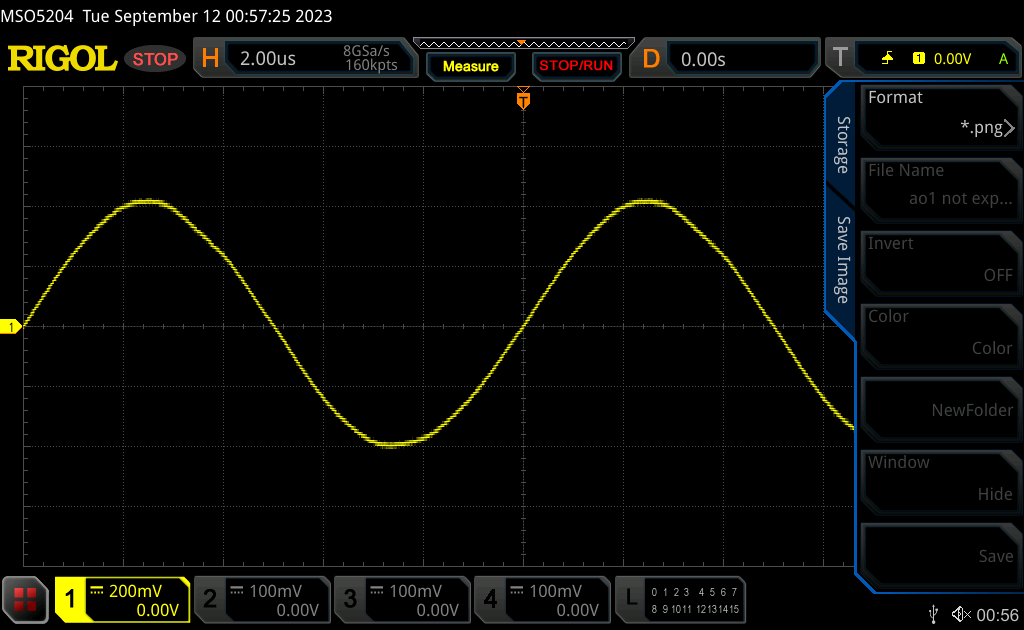

Exported
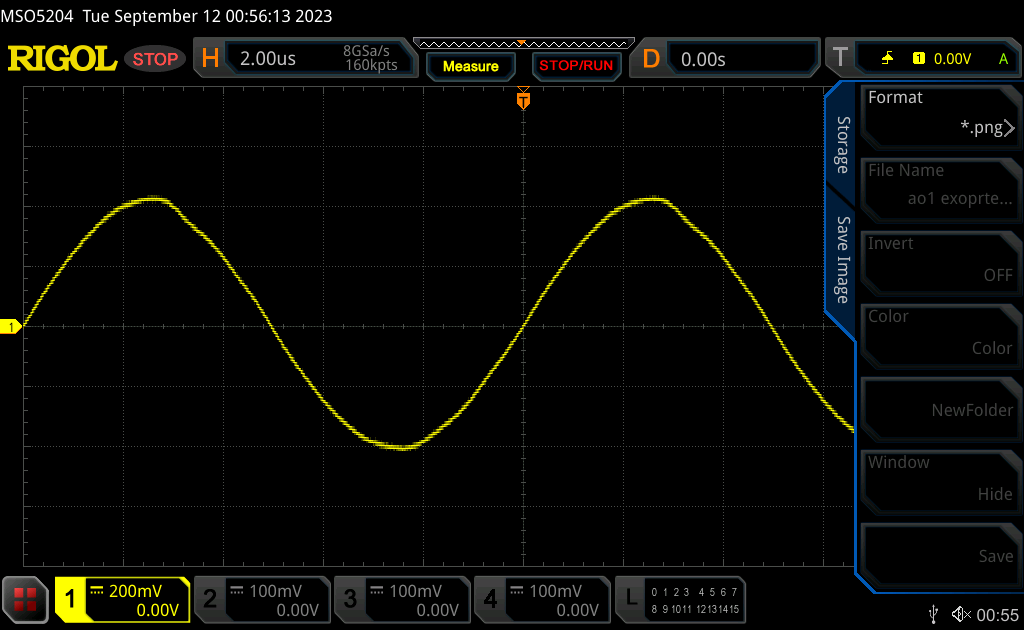

### Common block to test multiple cards

In [1]:
from streamer import NIStreamer
import numpy as np
from utils import iplot

In [2]:
ni_streamer = NIStreamer()

In [3]:
TRIG_LINE = 'PXI_Trig0'
REF_CLK_LINE = 'PXI_Trig7'

In [11]:
# Availble cards:
# ao_name_list = ['PXI1Slot3', 'PXI1Slot5']
# mf_name_list = ['PXI1Slot4']
# do_name_list = ['PXI1Slot6', 'PXI1Slot7', 'PXI1Slot8', 'PXI1Slot9']

In [4]:
ao_name_list = ['PXI1Slot3', 'PXI1Slot5']
mf_name_list = ['PXI1Slot4']
do_name_list = ['PXI1Slot6', 'PXI1Slot7', 'PXI1Slot8', 'PXI1Slot9']

# =========================================================================
# Add all cards ===========================================================
# =========================================================================

ao_proxy_list = []
do_proxy_list = []
mf_proxy_list = []

# AO cards
for max_name in ao_name_list:
    ao_proxy_list.append(ni_streamer.add_ao_card(
        max_name=max_name, 
        samp_rate=1e6
    ))
    
# MF cards
for max_name in mf_name_list:
    mf_proxy_list.append(ni_streamer.add_ao_card(
        max_name=max_name, 
        samp_rate=1e6
    ))

# DO cards
for max_name in do_name_list:
    do_proxy_list.append(ni_streamer.add_do_card(
        max_name=max_name, 
        samp_rate=10e6
    ))
    
# =========================================================================
# Configure start trigger and reference/sample clock ======================
# =========================================================================

# Main card (always PXI1Slot3)
ao_proxy_list[0].cfg_start_trig(line=TRIG_LINE, export=True)
ao_proxy_list[0].cfg_ref_clk(line=REF_CLK_LINE, export=True)

# Secondary cards
if len(ao_proxy_list) > 1:
    for ao_card in ao_proxy_list[1:]:
        ao_card.cfg_start_trig(line=TRIG_LINE)
        ao_card.cfg_ref_clk(line=REF_CLK_LINE)
    
for mf_card in mf_proxy_list:
    mf_card.cfg_start_trig(line=TRIG_LINE)
    mf_card.cfg_ref_clk(line=REF_CLK_LINE)
    
for do_card in do_proxy_list:
    do_card.cfg_start_trig(line=TRIG_LINE)
    do_card.cfg_samp_clk_src(src=REF_CLK_LINE)
    
# =========================================================================
# Add all channels ========================================================
# =========================================================================

ao_bank = []
do_bank = []

for ao_card in ao_proxy_list:
    for chan_idx in range(8):
        ao_bank.append(
            ao_card.add_chan(chan_idx=4*chan_idx)
        )
    
for mf_card in mf_proxy_list:
    for chan_idx in range(4):
        ao_bank.append(
            mf_card.add_chan(chan_idx=chan_idx)
        )
    
for do_card in do_proxy_list:
    for port_idx in range(4):
        for line_idx in range(8):
            do_bank.append(do_card.add_chan(
                port_idx=port_idx,
                line_idx=line_idx
            ))
            
print(f'AO chan num: {len(ao_bank)}')
print(f'DO chan num: {len(do_bank)}')

AO chan num: 20
DO chan num: 128


In [5]:
ao_bank[0]

Channel ao0 on card PXI1Slot3

In [6]:
ao_bank[1]

Channel ao4 on card PXI1Slot3

In [37]:
ni_streamer.clear_edit_cache()

total_dur = 10.0
instr_dur = 10e-3
instr_num = int(total_dur // instr_dur)

buf = 50e-6

# AO pulse settings
amp = 0.5
freq = 100e3

t = 0
for idx in range(instr_num):
    
    for ao_chan in ao_bank:
        ao_chan.sine(
            t=t, dur=instr_dur - buf,
            amp=amp, freq=freq
        )
    for do_chan in do_bank:
        do_chan.go_high(t=t)
        do_chan.go_low(t=t + instr_dur - buf)
        
    t += instr_dur
    
print(f'instr_num = {instr_num}')

instr_num = 5000
Wall time: 4.9 s


In [8]:
# Plot

chan_proxy_list = []
chan_proxy_list.extend(ao_bank[:1] + ao_bank[-1:])
chan_proxy_list.extend(do_bank[:1] + do_bank[-1:])

iplot(
    chan_list=chan_proxy_list,
    t_end=0.1,
    nsamps=1e5
)

In [38]:
ni_streamer.compile()

Wall time: 1.76 s


0.0099991

In [47]:
ni_streamer.stream_exp(nreps=1)

In [48]:
ni_streamer.reset_all()

#### Only main AO card (essentially previous test)

```
ao_name_list = ['PXI1Slot3']
mf_name_list = []
do_name_list = []

```

- Start trigger and samp/ref clock config commented out

- Only add `ao0`

**Result:**
everything is correct (10us sine period, 10 ms block, 50 us gaps, amplitude just above 400 mV)

```
ao_name_list = ['PXI1Slot3']
mf_name_list = []
do_name_list = []

```

- Start trigger and samp/ref clock config commented out

- Only add `ao0` and `ao4`

**Result: significan distortions**

- sine period is 5 us (should be 10 us)

- pulse-block duration is 5 ms (should be 10 ms)

- inter-pulse gap is 20 us (should be 50 us)

- overall dc-offset modulation

Testing AO card alone (all 8 1MSa channels):

0, 4, 8 - Ok
24 - all timing is correct, but sine shape is distorted

In [ ]:
# ao_name_list = ['PXI1Slot3', 'PXI1Slot5']
# mf_name_list = ['PXI1Slot4']
# do_name_list = ['PXI1Slot6', 'PXI1Slot7', 'PXI1Slot8', 'PXI1Slot9']

### Export trig/ref_clk and hook-up 